# Solar Analysis Program: A Step-by-Step Guide

The primary purpose of this program is to identify the optimal solar panel tilt strategy to maximize energy capture by comparing six different approaches, or "Arrangements."

---

## Step 1: Setup and Preparation

* **Start**: The program begins execution.
* **Define Constants**: It establishes unchangeable key values such as Gainesville's latitude (29.65°), the Earth's tilt (23.45°), and the months designated as summer or winter.
* **Load Data**: The program reads solar energy data from a `.csv` file for a specified year, like 2023. This file provides hourly details on sunlight (DHI and DNI) and the sun's declination angle.

---

## Step 2: Core Calculation Logic

This section serves as the program's engine and is utilized in all subsequent steps.

### Create a Calculation Function (Calculate Energy for a Tilt)

This function requires a **tilt angle**, a **list of months**, and the **sky condition** ('cloudy' or 'clear') as inputs. It then calculates the total solar energy (GHI) that a panel would receive at that specific tilt angle for every hour within the given months. The formula used accounts for the panel's tilt, the location's latitude, and the sun's hourly declination angle. The function returns the total energy for the entire period by summing the energy from all hours.

### Create an Optimization Function (Find Best Tilt)

This function takes a **list of months** and the **sky condition** as inputs. It evaluates every possible whole-number tilt angle from 0° to 90°, using the `Calculate Energy for a Tilt` function to determine the energy generated at each angle. The function identifies the tilt angle that yields the most energy and returns the **best tilt angle** along with the **maximum energy** value.

---

## Step 3: Analyze the Six Arrangements

The program assesses six strategies to determine the total energy each would generate over a full year.

* **Arrangement 1 (0° Fixed)**: The `Calculate Energy for a Tilt` function is used with the angle set to 0° for all 12 months.
* **Arrangement 2 (29° Fixed)**: The `Calculate Energy for a Tilt` function is used with the angle set to 29° (the latitude) for all 12 months.
* **Arrangement 3 (Two-Season Fixed)**: A "summer tilt" (29° - 11.7°) and a "winter tilt" (29° + 11.7°) are calculated. The energy for the summer and winter months is calculated using their respective tilts, and the results are added together for a yearly total.
* **Arrangement 4 (Monthly Optimal)**: The `Find Best Tilt` function is used for each month from January to December to find the best angle for each month. The maximum energy from all 12 months is then summed for a yearly total.
* **Arrangement 5 (Two-Season Optimal)**: The `Find Best Tilt` function is used once for all summer months combined and once for all winter months combined to find the single best tilt for each season. The two maximum energy results are then added together for a yearly total.
* **Arrangement 6 (Annual Optimal)**: The `Find Best Tilt` function is used for all 12 months at once to determine the single best tilt for the entire year.

---

## Step 4: Final Output and Visualization

* **Create Summary Table**: The program organizes the total yearly energy from all six arrangements into a table for comparison.
* **Generate Charts**: Graphs are created to visualize the results, including a bar chart comparing the total annual energy from each arrangement, a line chart showing the panel tilt angle for each strategy over the year, and monthly bar charts comparing specific pairs of arrangements.
* **End**: The program concludes after displaying the tables and charts.

In [1]:
pip install pandas matplotlib

--- Starting Full Solar Analysis for 2023 ---

--- Annual GHI Output Table by Arrangement (2023) ---
                              Cloudy Sky GHI Clear Sky GHI
Arr. 1: 0° Fixed                   2,215,915     2,931,221
Arr. 2: 29° Fixed (Lat)            2,446,077     3,281,576
Arr. 3: Two Fixed (Lat±11.7°)      2,501,214     3,371,934
Arr. 4: Monthly Optimal            2,517,552     3,398,906
Arr. 5: Summer/Winter Optimal      2,502,981     3,375,555
Arr. 6: Annual Optimal             2,446,111     3,281,849


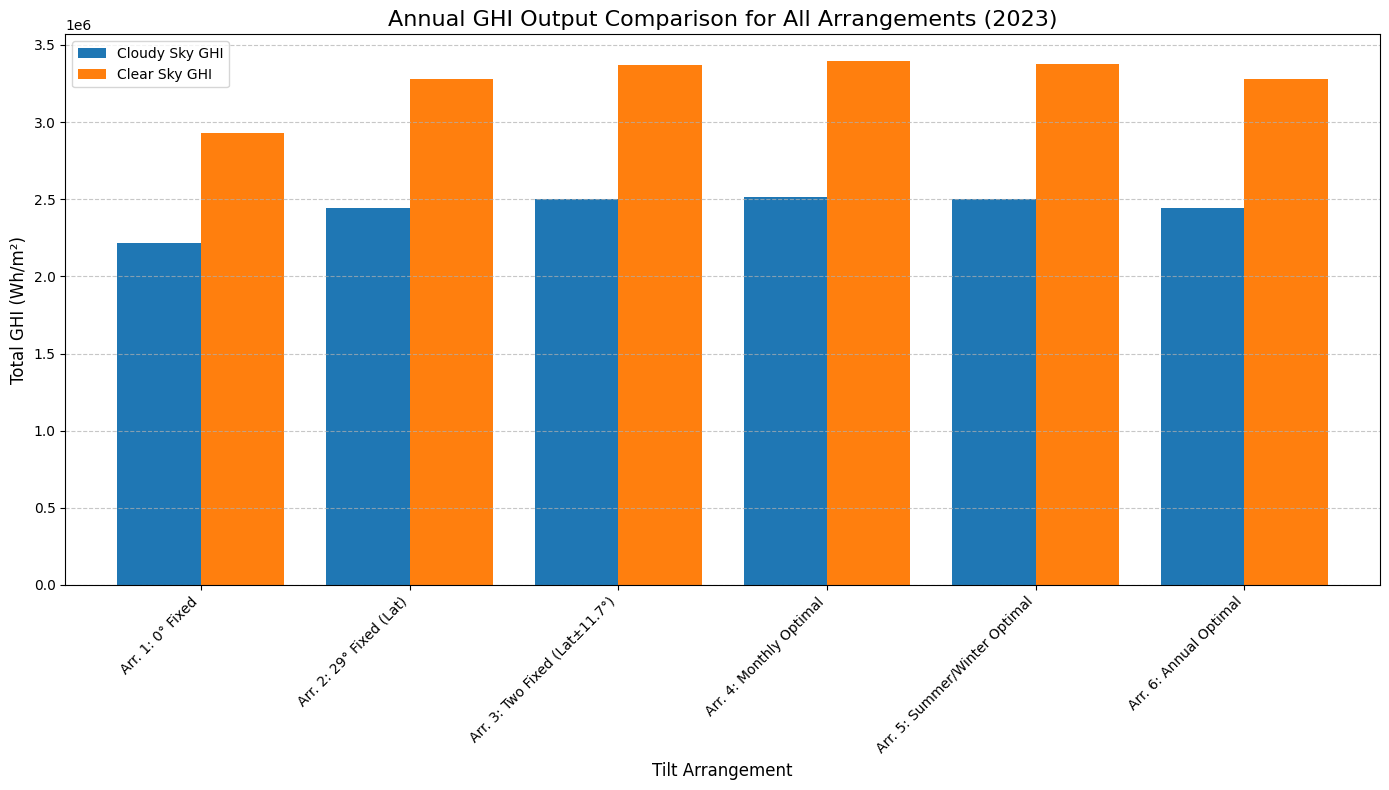


--- 3-Month Sliding Window Analysis Table (2023) ---
 Window  Optimal Tilt (Cloudy)
Jan-Mar                     41
Feb-Apr                     32
Mar-May                     22
Apr-Jun                     13
May-Jul                      9
Jun-Aug                     10
Jul-Sep                     17
Aug-Oct                     28
Sep-Nov                     38
Oct-Dec                     46
Nov-Jan                     50
Dec-Feb                     48

--- Starting Full Solar Analysis for 2022 ---
Error: The file '2022_with_declination.csv' was not found.

Could not run analysis for 2022. Check if '2022_with_declination.csv' exists.

The Importance of the Hourly Declination Angle
The sun's declination angle—its angle north or south of the celestial equator—is not constant;
it changes continuously throughout the day and year. Early simulation models might simplify this
by using a single average declination angle for an entire day. However, this program improves
upon that by using a pre

In [2]:
# main_solar_analysis.py
"""
main_solar_analysis.py

This script performs a comprehensive solar panel tilt analysis to determine
the optimal tilt strategies for maximizing Global Horizontal Irradiance (GHI)
based on hourly solar data.

Author: Santhanam, Ganesan
Date: May 2, 2025
Affiliation: University Of Florida
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class SolarAnalysis:
    """
    A class to perform comprehensive solar panel tilt analysis based on GHI data.
    """
    # --- Constants for the analysis ---
    LATITUDE_DEGREES = 29.651949  # Gainesville, FL
    LATITUDE_RADIANS = np.radians(LATITUDE_DEGREES)
    EARTH_AXIAL_TILT = 23.45

    WINTER_MONTHS = [10, 11, 12, 1, 2, 3]
    SUMMER_MONTHS = [4, 5, 6, 7, 8, 9]

    def __init__(self, csv_file_path: str):
        """
        Initializes the SolarAnalysis class by loading and preparing the dataset.

        Args:
            csv_file_path (str): The path to the input CSV file.
        """
        self.csv_file_path = csv_file_path
        self.data = self._load_and_prepare_data()

    def _load_and_prepare_data(self):
        """
        Loads the CSV file into a pandas DataFrame and performs initial cleaning.

        Returns:
            pd.DataFrame: A prepared DataFrame or None if loading fails.
        """
        try:
            df = pd.read_csv(self.csv_file_path)
            # Ensure essential columns are numeric
            numeric_cols = ['DHI', 'DNI', 'Clearsky DHI', 'Clearsky DNI', 'Declination Angle', 'Month']
            for col in numeric_cols:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            df.dropna(subset=numeric_cols, inplace=True)
            # Pre-calculate declination in radians
            df['Declination Angle Rad'] = np.radians(df['Declination Angle'])
            return df
        except FileNotFoundError:
            print(f"Error: The file '{self.csv_file_path}' was not found.")
            return None
        except Exception as e:
            print(f"An error occurred while loading the data: {e}")
            return None

    def calculate_ghi_for_tilt(self, tilt_degrees: float, months: list, sky_condition: str) -> float:
        """
        Calculates the total GHI for a given set of months and a fixed tilt angle.

        Args:
            tilt_degrees (float): The panel tilt angle in degrees.
            months (list): A list of month numbers to include in the calculation.
            sky_condition (str): 'cloudy' or 'clear'.

        Returns:
            float: The sum of GHI for the period.
        """
        if self.data is None:
            return 0.0

        dhi_col = 'DHI' if sky_condition == 'cloudy' else 'Clearsky DHI'
        dni_col = 'DNI' if sky_condition == 'cloudy' else 'Clearsky DNI'

        df_period = self.data[self.data['Month'].isin(months)].copy()

        # Filter out night hours or zero-radiation hours to speed up calculation
        df_period = df_period[~((df_period[dhi_col] == 0) & (df_period[dni_col] == 0))]

        if df_period.empty:
            return 0.0

        panel_tilt_rad = np.radians(tilt_degrees)

        # Vectorized calculation for efficiency
        declination_rad = df_period['Declination Angle Rad'].values
        dhi = df_period[dhi_col].values
        dni = df_period[dni_col].values

        theta_angle_rad = self.LATITUDE_RADIANS - panel_tilt_rad - declination_rad
        cos_theta = np.cos(theta_angle_rad)

        # Only consider positive contributions from DNI (when the sun is in front of the panel)
        dni_contribution = np.where(cos_theta > 0, cos_theta * dni, 0)

        ghi_output = dhi + dni_contribution
        return np.sum(ghi_output)

    def find_optimal_tilt(self, months: list, sky_condition: str) -> tuple:
        """
        Finds the single optimal tilt that maximizes GHI for a given period.

        Args:
            months (list): A list of month numbers for the optimization period.
            sky_condition (str): 'cloudy' or 'clear'.

        Returns:
            tuple: (best_tilt, max_ghi)
        """
        max_ghi = -1
        best_tilt = -1

        for tilt in range(0, 91):  # Iterate from 0 to 90 degrees
            ghi = self.calculate_ghi_for_tilt(tilt, months, sky_condition)
            if ghi > max_ghi:
                max_ghi = ghi
                best_tilt = tilt

        return best_tilt, max_ghi

    # --- Arrangement Analyses ---

    def analyze_arrangement_1(self, sky_condition: str) -> float:
        """Arrangement 1: Fixed 0 degrees all year."""
        return self.calculate_ghi_for_tilt(0, list(range(1, 13)), sky_condition)

    def analyze_arrangement_2(self, sky_condition: str) -> float:
        """Arrangement 2: Fixed at latitude (29 degrees) all year."""
        return self.calculate_ghi_for_tilt(self.LATITUDE_DEGREES, list(range(1, 13)), sky_condition)

    def analyze_arrangement_3(self, sky_condition: str) -> float:
        """Arrangement 3: Two fixed tilts based on latitude +/- half of Earth's axial tilt."""
        adjustment = self.EARTH_AXIAL_TILT / 2
        summer_tilt = self.LATITUDE_DEGREES - adjustment
        winter_tilt = self.LATITUDE_DEGREES + adjustment

        ghi_summer = self.calculate_ghi_for_tilt(summer_tilt, self.SUMMER_MONTHS, sky_condition)
        ghi_winter = self.calculate_ghi_for_tilt(winter_tilt, self.WINTER_MONTHS, sky_condition)

        return ghi_summer + ghi_winter

    def analyze_arrangement_4(self, sky_condition: str) -> float:
        """Arrangement 4: Monthly optimal tilts."""
        total_ghi = 0
        for month in range(1, 13):
            _, max_ghi = self.find_optimal_tilt([month], sky_condition)
            total_ghi += max_ghi
        return total_ghi

    def analyze_arrangement_5(self, sky_condition: str) -> float:
        """Arrangement 5: Optimized tilt for summer and winter periods."""
        _, ghi_summer = self.find_optimal_tilt(self.SUMMER_MONTHS, sky_condition)
        _, ghi_winter = self.find_optimal_tilt(self.WINTER_MONTHS, sky_condition)
        return ghi_summer + ghi_winter

    def analyze_arrangement_6(self, sky_condition: str) -> float:
        """Arrangement 6: Single optimal tilt for the entire year."""
        _, max_ghi = self.find_optimal_tilt(list(range(1, 13)), sky_condition)
        return max_ghi

    # --- Sliding Window Analysis ---

    def analyze_sliding_window(self, window_size: int, sky_condition: str) -> pd.DataFrame:
        """
        Performs a sliding window analysis to find optimal tilts for rolling periods.

        Args:
            window_size (int): The number of months in each window.
            sky_condition (str): 'cloudy' or 'clear'.

        Returns:
            pd.DataFrame: A DataFrame containing the results.
        """
        results = []
        month_names = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                       7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

        for i in range(1, 13):
            months_in_window = [(m - 1) % 12 + 1 for m in range(i, i + window_size)]

            # Create a name for the window (e.g., "Jan-Mar")
            start_month_name = month_names[months_in_window[0]]
            end_month_name = month_names[months_in_window[-1]]
            window_name = f"{start_month_name}-{end_month_name}"

            best_tilt, _ = self.find_optimal_tilt(months_in_window, sky_condition)
            results.append({"Window": window_name, f"Optimal Tilt ({sky_condition.capitalize()})": best_tilt})

        return pd.DataFrame(results)

# --- Plotting and Reporting Functions ---

def plot_arrangement_comparison(results_df: pd.DataFrame, year: int):
    """Plots a bar chart comparing the GHI of all arrangements."""
    results_df.plot(
        kind='bar',
        figsize=(14, 8),
        width=0.8
    )
    plt.title(f'Annual GHI Output Comparison for All Arrangements ({year})', fontsize=16)
    plt.ylabel('Total GHI (Wh/m²)', fontsize=12)
    plt.xlabel('Tilt Arrangement', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_sliding_window_analysis(df_2022: pd.DataFrame, df_2023: pd.DataFrame):
    """Plots the sliding window analysis results for two years."""
    plt.figure(figsize=(14, 8))
    plt.plot(df_2022['Window'], df_2022.iloc[:, 1], marker='o', linestyle='-', label='2022 Optimal Tilt')
    plt.plot(df_2023['Window'], df_2023.iloc[:, 1], marker='x', linestyle='--', label='2023 Optimal Tilt')

    plt.title('3-Month Sliding Window Optimal Tilt Comparison (Cloudy Sky)', fontsize=16)
    plt.xlabel('3-Month Window', fontsize=12)
    plt.ylabel('Optimal Panel Tilt (Degrees)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(np.arange(0, 61, 5))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def print_declination_paragraph():
    """Prints an explanatory paragraph about the declination angle's impact."""
    print("\n" + "="*50)
    print("The Importance of the Hourly Declination Angle")
    print("="*50)
    print(
        "The sun's declination angle—its angle north or south of the celestial equator—is not constant;\n"
        "it changes continuously throughout the day and year. Early simulation models might simplify this\n"
        "by using a single average declination angle for an entire day. However, this program improves\n"
        "upon that by using a precise, hourly declination angle.\n\n"
        "This higher resolution is critical for accuracy. The core of the GHI calculation depends on the\n"
        "angle of incidence (theta), which is a function of latitude, panel tilt, and the declination angle.\n"
        "By updating the declination for each hour, the simulation accurately captures the sun's changing\n"
        "path across the sky. This directly impacts the calculated contribution of Direct Normal Irradiance (DNI)\n"
        "to the panel's surface, leading to a more realistic and reliable estimation of the total energy\n"
        "output for any given tilt."
    )
    print("="*50 + "\n")


# --- Main Execution Block ---

if __name__ == "__main__":
    # ===== RUN ANALYSIS FOR 2023 =====
    YEAR_TO_ANALYZE = 2023
    FILE_PATH = f'{YEAR_TO_ANALYZE}_with_declination.csv'

    print(f"--- Starting Full Solar Analysis for {YEAR_TO_ANALYZE} ---")

    analyzer_2023 = SolarAnalysis(FILE_PATH)

    if analyzer_2023.data is not None:
        # 1. Run all arrangement analyses
        arrangements = {
            "Arr. 1: 0° Fixed": (analyzer_2023.analyze_arrangement_1, {}),
            "Arr. 2: 29° Fixed (Lat)": (analyzer_2023.analyze_arrangement_2, {}),
            "Arr. 3: Two Fixed (Lat±11.7°)": (analyzer_2023.analyze_arrangement_3, {}),
            "Arr. 4: Monthly Optimal": (analyzer_2023.analyze_arrangement_4, {}),
            "Arr. 5: Summer/Winter Optimal": (analyzer_2023.analyze_arrangement_5, {}),
            "Arr. 6: Annual Optimal": (analyzer_2023.analyze_arrangement_6, {}),
        }

        results = {}
        for name, (func, args) in arrangements.items():
            results[name] = {
                'Cloudy Sky GHI': func(sky_condition='cloudy', **args),
                'Clear Sky GHI': func(sky_condition='clear', **args)
            }

        results_df_2023 = pd.DataFrame(results).T
        # Format for better readability
        results_df_2023['Cloudy Sky GHI'] = results_df_2023['Cloudy Sky GHI'].map('{:,.0f}'.format)
        results_df_2023['Clear Sky GHI'] = results_df_2023['Clear Sky GHI'].map('{:,.0f}'.format)

        print("\n--- Annual GHI Output Table by Arrangement (2023) ---")
        print(results_df_2023)

        # 2. Plot the arrangement comparison
        plot_arrangement_comparison(pd.DataFrame(results).T, YEAR_TO_ANALYZE)

        # 3. Sliding Window Analysis for 2023
        print("\n--- 3-Month Sliding Window Analysis Table (2023) ---")
        sliding_window_cloudy_2023 = analyzer_2023.analyze_sliding_window(window_size=3, sky_condition='cloudy')
        print(sliding_window_cloudy_2023.to_string(index=False))

        # ===== RUN ANALYSIS FOR 2022 =====
        YEAR_TO_ANALYZE_2 = 2022
        FILE_PATH_2 = f'{YEAR_TO_ANALYZE_2}_with_declination.csv'

        print(f"\n--- Starting Full Solar Analysis for {YEAR_TO_ANALYZE_2} ---")

        analyzer_2022 = SolarAnalysis(FILE_PATH_2)

        if analyzer_2022.data is not None:
            # We only need the sliding window data for the final graph
            sliding_window_cloudy_2022 = analyzer_2022.analyze_sliding_window(window_size=3, sky_condition='cloudy')
            print(f"\n--- 3-Month Sliding Window Analysis Table (2022) ---")
            print(sliding_window_cloudy_2022.to_string(index=False))

            # 4. Plot sliding window comparison
            plot_sliding_window_analysis(sliding_window_cloudy_2022, sliding_window_cloudy_2023)
        else:
            print(f"\nCould not run analysis for {YEAR_TO_ANALYZE_2}. Check if '{FILE_PATH_2}' exists.")

        # 5. Print the final paragraph
        print_declination_paragraph()

    else:
        print(f"\nCould not run analysis for {YEAR_TO_ANALYZE}. Program will exit.")

--- Generating Visualization Suite for 2023 (Cloudy Sky) ---

Generating monthly comparison charts...


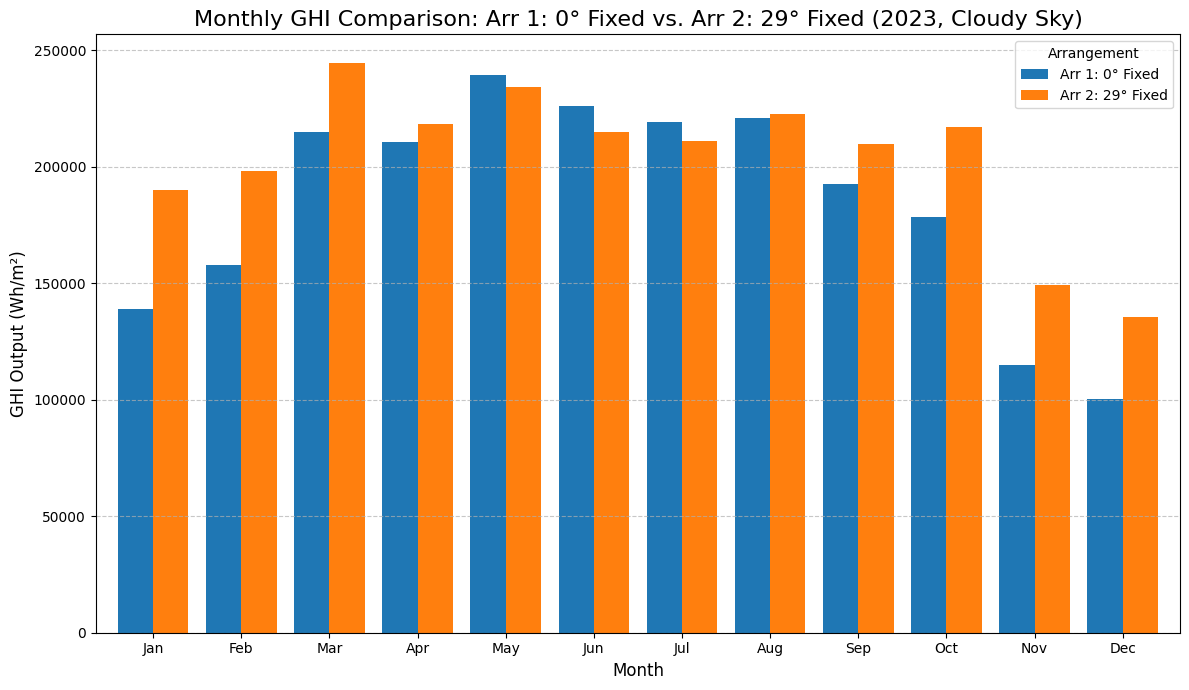

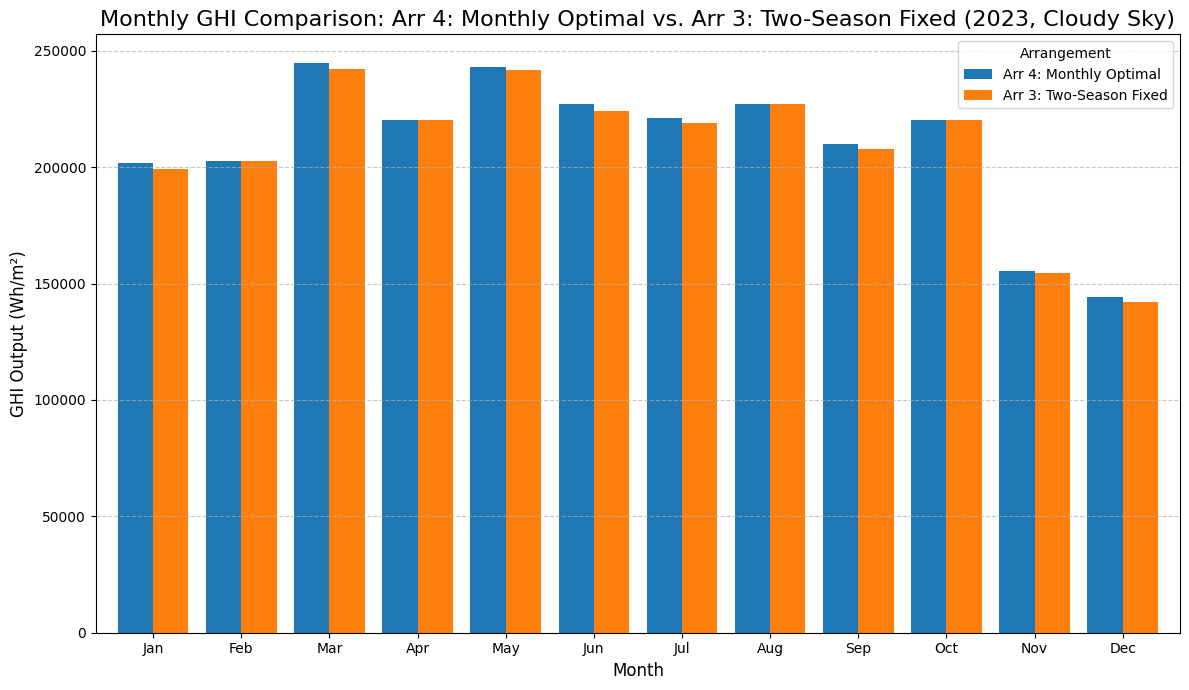

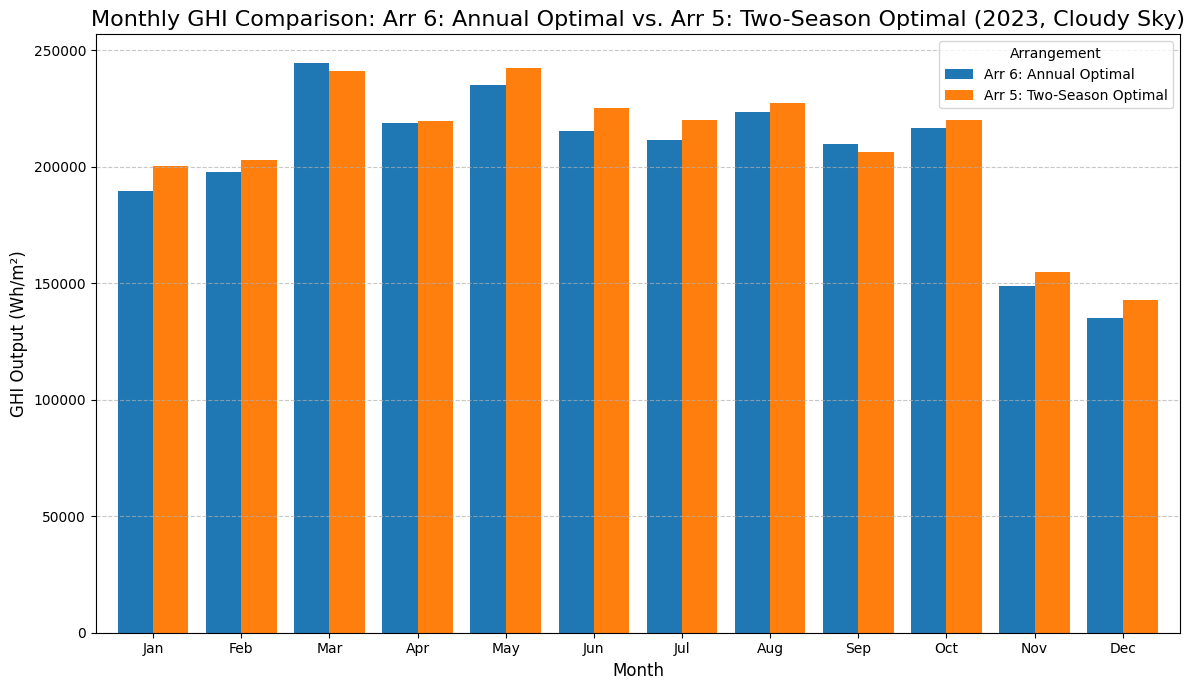

Generating tilt strategy timeline chart...


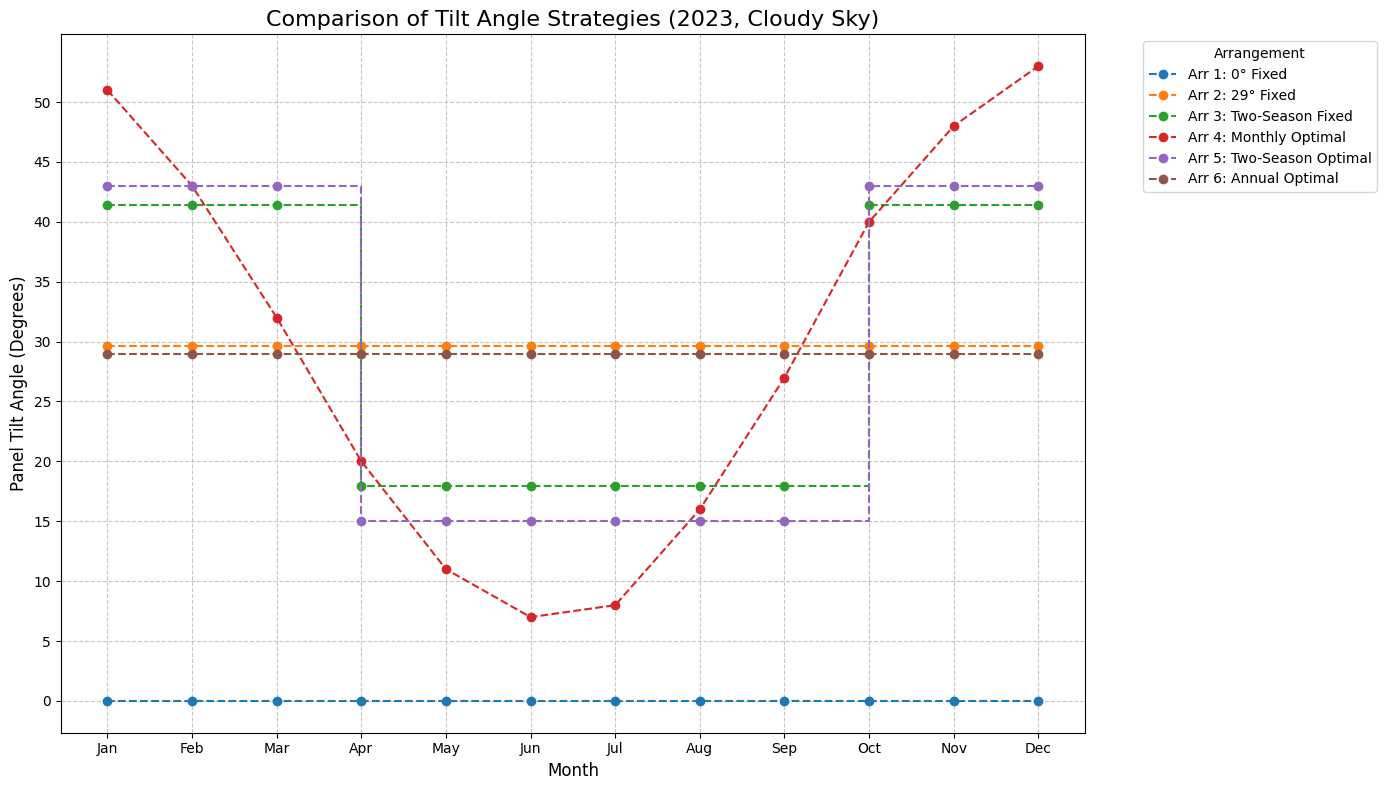

Generating cumulative gain chart...


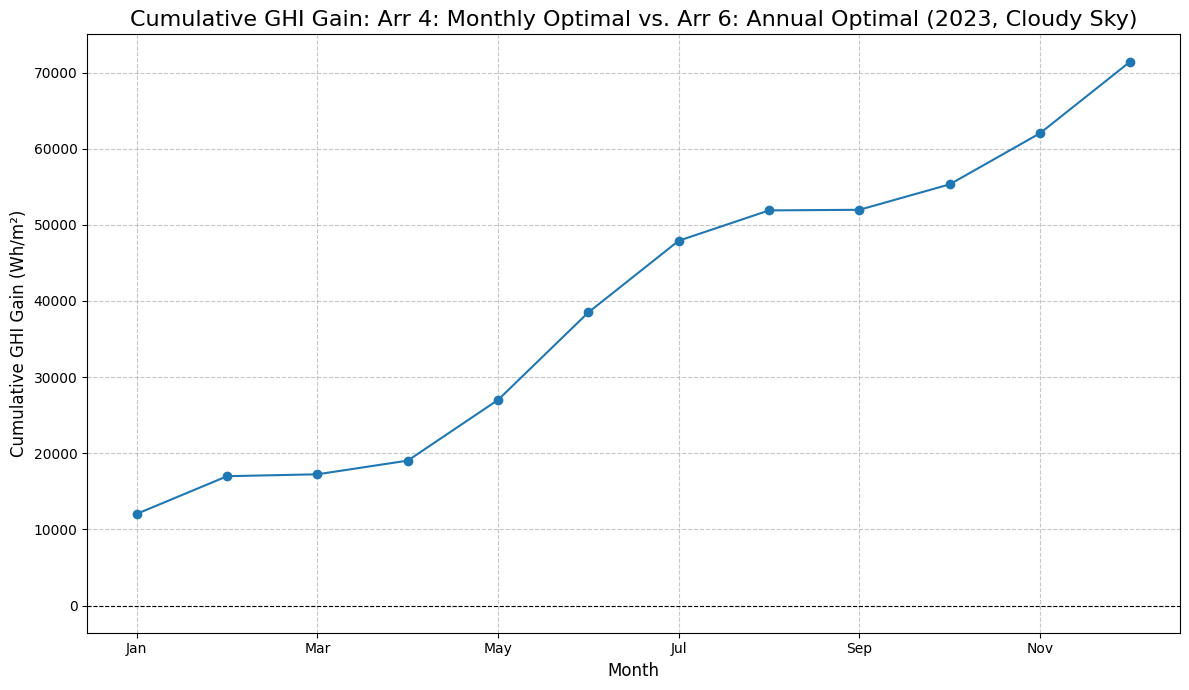


--- All visualizations have been generated. ---


In [4]:
# generate_visualizations.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from main_solar_analysis import SolarAnalysis # Import the class from the other file

def get_monthly_ghi_data(analyzer: SolarAnalysis, sky_condition: str) -> pd.DataFrame:
    """
    Calculates the GHI for every month for each of the 6 arrangements.

    Args:
        analyzer: An instantiated SolarAnalysis object.
        sky_condition: 'cloudy' or 'clear'.

    Returns:
        A DataFrame with months as rows and arrangements as columns.
    """

    # --- Tilts for each arrangement ---
    # Arr 4: Find optimal tilt for each month
    monthly_tilts_arr4 = [analyzer.find_optimal_tilt([m], sky_condition)[0] for m in range(1, 13)]

    # Arr 5: Find one optimal tilt for summer and one for winter
    opt_tilt_summer, _ = analyzer.find_optimal_tilt(analyzer.SUMMER_MONTHS, sky_condition)
    opt_tilt_winter, _ = analyzer.find_optimal_tilt(analyzer.WINTER_MONTHS, sky_condition)
    monthly_tilts_arr5 = [opt_tilt_summer if m in analyzer.SUMMER_MONTHS else opt_tilt_winter for m in range(1, 13)]

    # Arr 6: Find one optimal tilt for the whole year
    opt_tilt_annual, _ = analyzer.find_optimal_tilt(list(range(1, 13)), sky_condition)

    # --- Collect monthly GHI data ---
    data = {}
    month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    for i, month_name in enumerate(month_names):
        month_num = i + 1

        # Calculate GHI for this month using the tilt defined by each arrangement
        adjustment = analyzer.EARTH_AXIAL_TILT / 2

        data.setdefault("Month", []).append(month_name)
        data.setdefault("Arr 1: 0° Fixed", []).append(analyzer.calculate_ghi_for_tilt(0, [month_num], sky_condition))
        data.setdefault("Arr 2: 29° Fixed", []).append(analyzer.calculate_ghi_for_tilt(analyzer.LATITUDE_DEGREES, [month_num], sky_condition))

        # Arr 3 uses different tilts for summer/winter
        tilt_arr3 = (analyzer.LATITUDE_DEGREES - adjustment) if month_num in analyzer.SUMMER_MONTHS else (analyzer.LATITUDE_DEGREES + adjustment)
        data.setdefault("Arr 3: Two-Season Fixed", []).append(analyzer.calculate_ghi_for_tilt(tilt_arr3, [month_num], sky_condition))

        data.setdefault("Arr 4: Monthly Optimal", []).append(analyzer.calculate_ghi_for_tilt(monthly_tilts_arr4[i], [month_num], sky_condition))
        data.setdefault("Arr 5: Two-Season Optimal", []).append(analyzer.calculate_ghi_for_tilt(monthly_tilts_arr5[i], [month_num], sky_condition))
        data.setdefault("Arr 6: Annual Optimal", []).append(analyzer.calculate_ghi_for_tilt(opt_tilt_annual, [month_num], sky_condition))

    return pd.DataFrame(data).set_index("Month")

def plot_monthly_comparison(monthly_df: pd.DataFrame, arr1_name: str, arr2_name: str, sky_condition: str, year: int):
    """Generates a grouped bar chart comparing the monthly GHI of two arrangements."""

    df_to_plot = monthly_df[[arr1_name, arr2_name]]

    df_to_plot.plot(kind='bar', figsize=(12, 7), width=0.8)

    plt.title(f'Monthly GHI Comparison: {arr1_name} vs. {arr2_name} ({year}, {sky_condition.capitalize()} Sky)', fontsize=16)
    plt.ylabel('GHI Output (Wh/m²)', fontsize=12)
    plt.xlabel('Month', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Arrangement')
    plt.tight_layout()
    plt.show()

def plot_tilt_strategies(analyzer: SolarAnalysis, sky_condition: str, year: int):
    """Plots the tilt angles used by each arrangement over the year."""

    plt.figure(figsize=(14, 8))
    months = list(range(1, 13))
    month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    # --- Get tilts for each strategy ---
    tilts = {}
    tilts['Arr 1: 0° Fixed'] = [0] * 12
    tilts['Arr 2: 29° Fixed'] = [analyzer.LATITUDE_DEGREES] * 12

    adjustment = analyzer.EARTH_AXIAL_TILT / 2
    tilts['Arr 3: Two-Season Fixed'] = [(analyzer.LATITUDE_DEGREES - adjustment) if m in analyzer.SUMMER_MONTHS else (analyzer.LATITUDE_DEGREES + adjustment) for m in months]

    tilts['Arr 4: Monthly Optimal'] = [analyzer.find_optimal_tilt([m], sky_condition)[0] for m in months]

    opt_tilt_summer, _ = analyzer.find_optimal_tilt(analyzer.SUMMER_MONTHS, sky_condition)
    opt_tilt_winter, _ = analyzer.find_optimal_tilt(analyzer.WINTER_MONTHS, sky_condition)
    tilts['Arr 5: Two-Season Optimal'] = [opt_tilt_summer if m in analyzer.SUMMER_MONTHS else opt_tilt_winter for m in months]

    opt_tilt_annual, _ = analyzer.find_optimal_tilt(months, sky_condition)
    tilts['Arr 6: Annual Optimal'] = [opt_tilt_annual] * 12

    # --- Plotting ---
    for name, tilt_values in tilts.items():
        # Use drawstyle='steps-post' for step-like functions
        drawstyle = 'steps-post' if name in ['Arr 3: Two-Season Fixed', 'Arr 5: Two-Season Optimal'] else 'default'
        plt.plot(months, tilt_values, marker='o', linestyle='--', label=name, drawstyle=drawstyle)

    plt.title(f'Comparison of Tilt Angle Strategies ({year}, {sky_condition.capitalize()} Sky)', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Panel Tilt Angle (Degrees)', fontsize=12)
    plt.xticks(months, month_names)
    plt.yticks(np.arange(0, 51, 5))
    plt.legend(title='Arrangement', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_cumulative_gain(monthly_df: pd.DataFrame, base_arr: str, optimized_arr: str, sky_condition: str, year: int):
    """Plots the cumulative GHI gain of an optimized strategy over a base strategy."""

    gain = (monthly_df[optimized_arr] - monthly_df[base_arr]).cumsum()

    plt.figure(figsize=(12, 7))
    gain.plot(kind='line', marker='o', legend=False)

    plt.title(f'Cumulative GHI Gain: {optimized_arr} vs. {base_arr} ({year}, {sky_condition.capitalize()} Sky)', fontsize=16)
    plt.ylabel('Cumulative GHI Gain (Wh/m²)', fontsize=12)
    plt.xlabel('Month', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(True, linestyle='--', alpha=0.7)
    # Add a horizontal line at y=0 for reference
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.tight_layout()
    plt.show()

# --- Main Execution Block ---

if __name__ == "__main__":
    YEAR = 2023
    SKY_CONDITION = 'cloudy'  # Can be 'cloudy' or 'clear'
    FILE_PATH = f'{YEAR}_with_declination.csv'

    print(f"--- Generating Visualization Suite for {YEAR} ({SKY_CONDITION.capitalize()} Sky) ---")

    main_analyzer = SolarAnalysis(FILE_PATH)

    if main_analyzer.data is not None:
        # 1. Get the foundational monthly GHI data
        monthly_ghi_df = get_monthly_ghi_data(main_analyzer, SKY_CONDITION)

        # 2. Generate the requested comparison charts
        print("\nGenerating monthly comparison charts...")
        plot_monthly_comparison(monthly_ghi_df, "Arr 1: 0° Fixed", "Arr 2: 29° Fixed", SKY_CONDITION, YEAR)
        plot_monthly_comparison(monthly_ghi_df, "Arr 4: Monthly Optimal", "Arr 3: Two-Season Fixed", SKY_CONDITION, YEAR)
        plot_monthly_comparison(monthly_ghi_df, "Arr 6: Annual Optimal", "Arr 5: Two-Season Optimal", SKY_CONDITION, YEAR)

        # 3. Generate the tilt strategy timeline
        print("Generating tilt strategy timeline chart...")
        plot_tilt_strategies(main_analyzer, SKY_CONDITION, YEAR)

        # 4. Generate the cumulative gain chart
        print("Generating cumulative gain chart...")
        plot_cumulative_gain(monthly_ghi_df, "Arr 6: Annual Optimal", "Arr 4: Monthly Optimal", SKY_CONDITION, YEAR)

        print("\n--- All visualizations have been generated. ---")
    else:
        print("Could not generate visualizations due to data loading error.")